In [26]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.utils import np_utils
from sklearn.metrics import classification_report
from keras.regularizers import l2
from keras.preprocessing import sequence

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

In [41]:
mixeddataname = "mixed_20568.pkl"
modelname = 'LR.h5'

num_class = 2

size_batch = 10
num_epoch = 10
l2_lambda = 0.00001

stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer("[a-z']+")

### Method

In [28]:
def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(t) for t in tokens] 

def get_tf(data, use_idf, max_df=1.0, min_df=1, ngram_range=(1,1)):
    if use_idf:
        m = TfidfVectorizer(
            max_df=max_df,
            min_df=min_df, 
            stop_words='english', 
            ngram_range=ngram_range, 
            tokenizer=tokenize
        )
    else:
        m = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    
    d = m.fit_transform(data)
    return m, d

In [37]:
def getData(filename):
    print("---------------")
    print("| Getting data...")
    print("---------------")
    
    data = pd.read_pickle(filename)
    tfidf_m, tfidf_d = get_tf(data['reviewText'], use_idf=True, max_df=0.90, min_df=10)
    
    X = tfidf_d[0: tfidf_d.shape[0] - 20568 - 1]
    X_adv = tfidf_d[tfidf_d.shape[0] - 20568 -1: -1]
    
    data_Y = data.overall
    data_Y = np_utils.to_categorical(data_Y, num_class)
    Y = data_Y[0: tfidf_d.shape[0] - 20568 - 1]
    Y_adv = data_Y[tfidf_d.shape[0] - 20568 -1: -1]
    
    return X, Y, X_adv, Y_adv, len(tfidf_m.get_feature_names())

In [30]:
# def getData(filename):
#     print("---------------")
#     print("| Getting data...")
#     print("---------------")
    
#     data = pd.read_pickle(filename)
#     reviewTextList = data.reviewText.values
#     t.fit_on_texts(reviewTextList)
#     text = t.texts_to_matrix(reviewTextList, mode='count')
    
#     data_X = text
#     data_Y = data['overall']
#     data_Y = np_utils.to_categorical(data_Y, num_class)
    
#     return data_X, data_Y

In [31]:
def splitData(x, y):
    X_trains, X_test, Y_trains, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    X_train, X_validation, Y_train, Y_validation = train_test_split(X_trains, Y_trains, test_size=0.2, random_state=42)
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test

In [39]:
def train(x_train, x_validation, y_train, y_validation, dim_input, batch_size, epochs):
    print("---------------")
    print("| Training...")
    print("---------------")
    
    model = Sequential()
    model.add(Dense(2, input_dim=dim_input, activation='softmax', kernel_regularizer=l2(l2_lambda)))
    print(model.summary())
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])
    history=model.fit(x_train,y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_validation, y_validation),
                      )    
    plt.figure('categorical_accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Categorical Accuracy')
    plt.plot(history.history['categorical_accuracy'])
    plt.show()
    model.save(modelname)
    return model
    del model

In [33]:
def test(x_test, y_test):
    print("---------------")
    print("| Testing...")
    print("---------------")
    model = load_model(modelname)
    
    score = model.evaluate(x_test,y_test)
    print('Test loss:',score[0])
    print('Test accuracy:',score[1])
    
    y_test=np.argmax(y_test,axis=1)
    y_pred=model.predict_classes(x_test)
    
    print(classification_report(y_test,y_pred))

In [11]:
def main():
    X, Y = getData(dataname)
    
#     X_train, X_validation, X_test, Y_train, Y_validation, Y_test = splitData(X, Y)
#     train(X_train, X_validation, Y_train, Y_validation, size_batch, num_epoch)
#     test(X_test, Y_test)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    train(X_train, X_test, Y_train, Y_test, size_batch, num_epoch)
    test(X_test, Y_test)

In [45]:
# main()

### Test with Adversasial Dataset

In [38]:
X, Y, X_adv, Y_adv, dim_input = getData(mixeddataname)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

---------------
| Getting data...
---------------


---------------
| Training...
---------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 20152     
Total params: 20,152
Trainable params: 20,152
Non-trainable params: 0
_________________________________________________________________
None
Train on 82269 samples, validate on 20568 samples
Epoch 1/10
82269/82269 [==============================] - 45s 551us/step - loss: 0.4593 - categorical_accuracy: 0.8452 - val_loss: 0.3740 - val_categorical_accuracy: 0.8605
Epoch 2/10
82269/82269 [==============================] - 44s 531us/step - loss: 0.3456 - categorical_accuracy: 0.8714 - val_loss: 0.3456 - val_categorical_accuracy: 0.8670
Epoch 3/10
82269/82269 [==============================] - 48s 584us/step - loss: 0.3275 - categorical_accuracy: 0.8765 - val_loss: 0.3397 - val_categorical_accuracy: 0.8692
Epoch 4/10
82269/82269 [======================

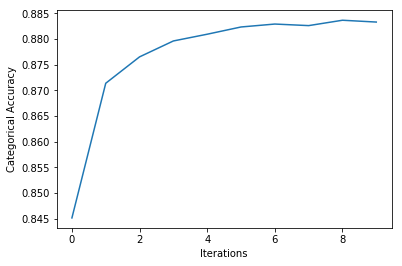

In [42]:
train(X_train, X_test, Y_train, Y_test, dim_input, size_batch, num_epoch)

In [43]:
test(X_test, Y_test)

---------------
| Testing...
---------------
20568/20568 [==============================] - 3s 166us/step
Test loss: 0.34081778760227144
Test accuracy: 0.8697977440916393
             precision    recall  f1-score   support

          0       0.87      0.88      0.87     10392
          1       0.87      0.86      0.87     10176

avg / total       0.87      0.87      0.87     20568



In [44]:
test(X_adv, Y_adv)

---------------
| Testing...
---------------
20568/20568 [==============================] - 4s 174us/step
Test loss: 0.47077871526970744
Test accuracy: 0.7988136911707506
             precision    recall  f1-score   support

          0       0.76      0.88      0.81     10330
          1       0.85      0.72      0.78     10238

avg / total       0.81      0.80      0.80     20568

